# Problem Set 4

In [1]:
# Import the needed libraries

import pandas as pd
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from scipy.optimize import root, minimize
import matplotlib.pyplot as plt
from jax import grad, jacobian, hessian, config, jit
import jax.numpy as jnp
import warnings

config.update("jax_enable_x64", True)

In [2]:
# Set global parameter values
beta = (5, 1, 1)
gamma = (2, 1, 1)

In [3]:
def load_mat_data(datapath, nrProducts, nrMarkets):
    """
    Purpose: Loads a .mat data file and returns a Pandas DataFrame.

    Parameters
    ----------
    datapath : str
        The path to the .mat file.

    nrProducts : int
        The number of products in the market data.
    
    nrMarkets : int
        The number of markets in the market data.
        
    Returns
    -------
    pd.DataFrame
        The market level data in the .mat data file converted to a Pandas DataFrame.
    pd.DataFrame
        The simulated alphas in the .mat data file converted to a Pandas DataFrame.
        
    Description
    -----------
    This function loads the .mat data using scipy.io.loadmat and collects the variable names and the 
    data (in numpy arrays), ignoring other items in the dictionary (such as the header). It then converts
    the cleaned dictionary into two DataFrames, one for the market level data and one for the simulated alphas in each market.
    """

    # Load the .mat data and format the X's appropriately
    mat = loadmat(datapath)
    mat = {k:v for k, v in mat.items() if k[0] != '_'}
    mat['x2'] = mat['x1'][:, 1]
    mat['x3'] = mat['x1'][:, 2]
    mat['x1'] = mat['x1'][:, 0]

    # Get the simulated alphas into one DataFrame
    alphas = mat['alphas']
    column_names = [i for i in range(alphas.shape[1])]
    df_alphas = pd.DataFrame(alphas, columns=column_names)
    mat.pop('alphas')

    # Store the market level data to a DataFrame
    df_mkt = pd.DataFrame({k: np.array(v).flatten(order='F') for k, v in mat.items()})

    # Add market and product ids to the market level data
    product_ids = [i+1 for i in range(nrProducts)] * nrMarkets
    market_ids = [i+1 for i in range(nrMarkets) for _ in range(nrProducts)]
    df_mkt['market_id'] = market_ids
    df_mkt['product_id'] = product_ids
    
    return df_mkt, df_alphas

In [4]:
def draw_epsilons(alphas):
    """
    Purpose: Draws epsilons from the specified distribution, to the same shape as alphas.

    Parameters
    ----------
    alphas : pd.DataFrame
        The DataFrame of alphas, in the form (Number of Consumers) x (Number of Markets).
        
    Returns
    -------
    pd.DataFrame
        The simulated epsilons in a Pandas DataFrame.
        
    Description
    -----------
    This function takes the simulated alphas for all consumers in all markets and simulates epsilons for each of them.
    """
    draws = np.random.gumbel(size=(alphas.shape[0], alphas.shape[1]))
    column_names = [i+1 for i in range(draws.shape[1])]
    df_epsilons = pd.DataFrame(draws, columns=column_names)
    return df_epsilons

In [5]:
df_3p, alphas_3p = load_mat_data('Simulation Data/100markets3products.mat', 3, 100)
df_5p, alphas_5p = load_mat_data('Simulation Data/100markets5products.mat', 5, 100)

In [6]:
epsilons_3p = draw_epsilons(alphas_3p)
epsilons_5p = draw_epsilons(alphas_5p)

In [7]:
# Calculate marginal costs for the firms
df_3p['mc'] = gamma[0] + gamma[1]*df_3p['w'] + gamma[2]*df_3p['Z'] + df_3p['eta']
df_5p['mc'] = gamma[0] + gamma[1]*df_5p['w'] + gamma[2]*df_5p['Z'] + df_5p['eta']

In [8]:
# Calculate profits per purchase for the firms
df_3p['Pi'] = df_3p['P_opt'] - df_3p['mc']
df_5p['Pi'] = df_5p['P_opt'] - df_5p['mc']

In [9]:
def calculate_welfare(data, alphas, epsilons):
    """
    Purpose: Calculates the consumer welfares based on the given market level data and the simulated consumers.

    Parameters
    ----------
    data : pd.DataFrame
        The DataFrame of market level data.

    alphas : pd.DataFrame
        The DataFrame of alphas, in the form (Number of Consumers) x (Number of Markets).

    epsilons : pd.DataFrame
        The DataFrame of epsilons, in the form (Number of Consumers) x (Number of Markets).
        
    Returns
    -------
    np.array
        The (Number of Consumers) x (Number of Markets) array of utilities (welfare) of each consumer in each market, conditional
        on them choosing optimally based on their utility function.
        
    Description
    -----------
    This function takes the market level data, and simulated alphas and epsilons and calculates the welfare for each consumer in each market,
    conditional on them choosing optimally based on their utility function parameters.
    """
    # Check that the alphas and epsilons agree on the number of markets
    assert len(alphas) == len(epsilons)

    # Store number of markets
    nrMarkets = len(alphas)

    # Store number of products
    nrProducts = data['product_id'].max()
    
    for market_id in range(1, nrMarkets+1):
        # Get the data for the market at hand
        mkt_data = data.loc[data['market_id']==market_id].copy()
        
        # Calculate the part of the utility that is independent from the consumer
        mkt_data['common_util'] = beta[0]*mkt_data['x1'] + beta[1]*mkt_data['x2'] + beta[2]*mkt_data['x3'] + mkt_data['xi_all']
        
        # Calculate consumer utilities
        utils = {}
        for product in range(1, nrProducts+1):
            utils[product] = (
                -alphas.iloc[market_id-1].values*mkt_data.loc[mkt_data['product_id']==product]['P_opt'].iloc[0]
                + epsilons.iloc[market_id-1].values
                + mkt_data.loc[mkt_data['product_id']==product]['common_util'].iloc[0]
            )

        # Stack utilities for each product in the market for each consumers into a matrix
        product_utilities = np.stack(tuple(utils.values()), axis=1)

        # Create a column of zeros with the same number of rows as there are consumers
        zero_column = np.zeros((product_utilities.shape[0], 1))
        
        # Concatenate the zero column to 'product_utilities', to store the utility from the outside option (zero)
        product_utilities = np.concatenate([product_utilities, zero_column], axis=1)

        mkt_welfare = np.amax(product_utilities, axis=1).reshape(500, -1)
        
        if market_id == 1:
            market_welfares = mkt_welfare
        else:
            market_welfares = np.hstack([market_welfares, mkt_welfare])
            
    return market_welfares

In [10]:
consumer_welfare_3p = calculate_welfare(df_3p, alphas_3p, epsilons_3p)
consumer_welfare_5p = calculate_welfare(df_5p, alphas_5p, epsilons_5p)

In [11]:
def plot_two_histograms(data1, data2, bins=500, labels=('Data 1', 'Data 2')):
    """
    Purpose: Plots two histograms side by side to compare the distributions of two different datasets.

    Parameters
    ----------
    data1 : np.array
        The first dataset, which can be a multi-dimensional NumPy array. All elements will be flattened for the histogram.
    
    data2 : np.array
        The second dataset, which can also be a multi-dimensional NumPy array. All elements will be flattened for the histogram.
    
    bins : int, optional
        The number of bins for each histogram (default is 50).
    
    labels : tuple of str, optional
        Labels for each dataset, used in the titles of the histograms (default is ('Data 1', 'Data 2')).
        
    Description
    -----------
    This function takes two datasets, flattens them into 1-dimensional arrays if necessary, and plots them as two
    histograms side by side in a single figure. It provides a visual comparison of the distributions in both datasets.
    """
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot the first histogram
    axes[0].hist(data1.flatten(), bins=bins)
    axes[0].set_title(f'{labels[0]}')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    
    # Plot the second histogram
    axes[1].hist(data2.flatten(), bins=bins)
    axes[1].set_title(f'{labels[1]}')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    
    # Show the plots
    plt.tight_layout()
    plt.show()

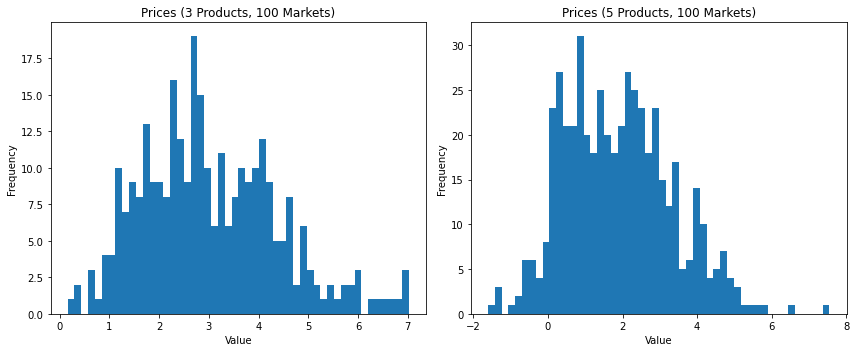

In [12]:
plot_two_histograms(df_3p['P_opt'].values, df_5p['P_opt'].values, bins=50, labels=('Prices (3 Products, 100 Markets)', 'Prices (5 Products, 100 Markets)'))

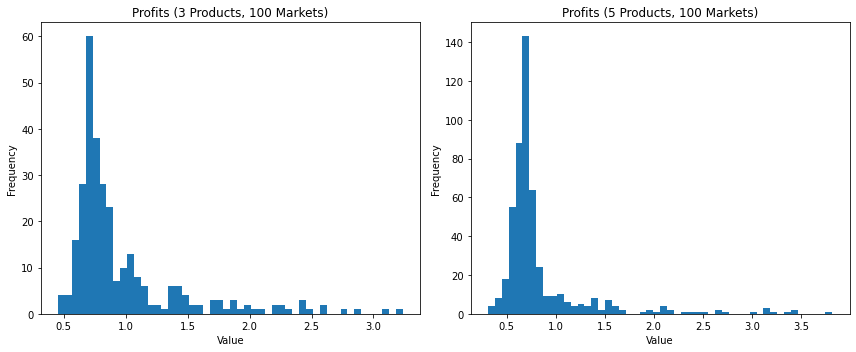

In [13]:
# NOTE: This is incomplete. Need to calculate gross profits accounting for the consumer choices. Currently, it's just per purchase profits.

plot_two_histograms(df_3p['Pi'].values, df_5p['Pi'].values, bins=50, labels=('Profits (3 Products, 100 Markets)', 'Profits (5 Products, 100 Markets)'))

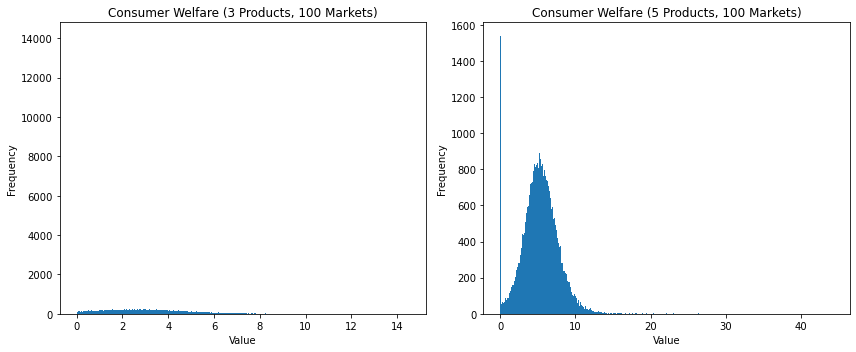

In [14]:
plot_two_histograms(consumer_welfare_3p, consumer_welfare_5p, labels=('Consumer Welfare (3 Products, 100 Markets)', 'Consumer Welfare (5 Products, 100 Markets)'))

# 2. BLP and Hausman Instruments

In [15]:
# Set the number of firms, markets, and simulated consumers in each market 
J = 3
M = 100
N = 500

In [16]:
# Set the number of BLP instruments
N_instruments = 7

### 1. (a)

NOTE: We assume the question asks us to use the $(J, M) = (3, 100)$ data set, since there is no data with 200 markets.

In [17]:
df_3p['P_other_markets'] = df_3p.groupby('product_id')['P_opt'].transform(
        lambda x: (x.sum() - x) / (len(x) - 1)
    )

In [18]:
xi = df_3p['xi_all'].values.reshape(J*M, 1)
X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
price = df_3p['P_opt'].values.reshape(J*M, 1)
price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)

In [19]:
(xi*X).mean(axis=0)

array([0.04346104, 0.02074192, 0.0355315 ])

In [20]:
(xi*price).mean()

0.2949581371489729

In [21]:
(xi*price_other_mkt).mean()

0.1436795476746802

### 1. (b)

Consider $E[\xi|X] = 0$ first. For the moment condition to be valid for all $X$ (including the firm's own product characteristics), we would need the observable product characteristics $X_{jm}$ to be independent of the unobserved product characteristics (or things like market-specific brand value), $\xi_{jm}$. In practice, this would mean that firms with certain types of observable product characteristics do not have systematically different unobserved product characteristics. This seems unlikely to hold in practice, since firms are able to both see the unobserved (to the econometrician) product characteristics before choosing the observed (again, to the econometrician) product characteristics. For example, we would expect that a "premium" car (something that is in $\xi$) typically has different product characteristics that a non-premium car. Still, to know whether this moment condition would be valid in this context, we would need more information on what type of products we are studying.

The moment condition is relevant though, as long as $X$ is included $Z_{jm}$, i.e. the product characteristics are costly. The relevance is then clear from the fact that prices are a function of marginal costs, which are a function of $X$.  

As for $E[\xi|p] = 0$, the validity depends on which prices we consider. With own prices, it's clear that validity is not satisfied, since in general, prices are higher for products with greater $\xi$, as firms choose prices with knowledge of their market-specific $\xi_{jm}$. But the mean independence might be satisfied for own prices in other markets (Hausman instruments), if we include firm fixed effects to control for the firm-level component of $\xi$ that is invariant accross markets and construct the moment condition with the market-specific part of $\xi$. Note that relevance is trivially satisfied in both these cases, since (1) prices are obviously correlated with themselves, and (2) prices in other markets are correlated with prices in a specific market because there is a common cost shifter for all markets, $W_j$. 

### 1. (c)

If the way firms choose product characteristics $X$ is such that the unobserved product characteristics are not observed before choosing observable characteristics, the BLP instruments can be used. Similarly, in the previous part we have argued that the Hausman instruments are relevant, and are also valid if there are e.g. no demand shocks that are common accross all markets or marketing campaings of the firms that include multiple markets.

### 2. (a)

To begin, we introduce some notation that is useful throughout the rest of the problem set. Let $S_{jm}$ be the observed market share of product $j$ in market $m$, and $S_m \equiv (S_{jm})_{j = 1}^J$. For each value of the parameter values $\theta$, there exists a unique mapping (as shown by Berry, 1994) between the observed market shares, $S_m$, and the vector of unobserved demand shocks $\xi_m$, defined by $s(\cdot)$:
$$
S_m = s(X_m, p_m, \xi_m; \theta),
$$
where the $X_m$ is the matrix of observed product characteristics, $p_m$ the vector of prices, and $\xi_m$ the vector of unobserved demand shocks, all in market $m$. The uniqueness of the mapping allows us to invert the market share function to arrive at:
$$
\xi_m(\theta) = s^{-1}(S_m; \theta),
$$
where we have shortened $s(\xi_m; \theta) \equiv s(X_m, p_m, \xi_m; \theta)$ for notational convenience. Finally, denote $\xi(\theta) = (\xi_m(\theta))_{m = 1}^M$.

We next write down the BLP moments. First, let $h(X, j, m)$ be a vector valued function of moments for firm $j$ in market $m$, based on all the observable product characteristics $X$ for all products and markets. The BLP instruments are the (observable) product characteristics of the firm $X_{jm}$, the sum of the characteristics of other products of the firm (in other markets) $\sum_{r \neq j, m' \neq m, r \in \mathcal{F}_j} X_{rm'}$, and the characteristics of other firms in the same market $\sum_{r \neq \mathcal{F}_j} X_{rm}$. We exclude the first element of $X_{jm}$, the constant, from all these instruments. Since there are two other product characteristics, $h(X)$ is a vector with $2 \times 3 = 6$ elements for each firm. The BLP moment is thus:
$$
E[\xi_{jm}h(X, j)] = 0.
$$

The empirical analogue of the BLP moment is:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J \xi_{jm} h(X, j, m).
$$
Let $s^{-1}_j(S_m; \theta)$ denote the $j$th element of $s^{-1}_j(S_m; \theta)$. We thus have:
$$
g(\xi(\theta)) = \frac{1}{M}\Sigma_{m = 1}^M \Sigma_{j = 1}^J s^{-1}_j(S_m; \theta) h(X, j, m).
$$

### 2. (b)

The objective function in the MPEC problem is simply:
$$
Q(\theta) \equiv g(\xi(\theta))^T W g(\xi(\theta)),
$$
for some weighting matrix $W$. We can thus write the MPEC problem in its entirety as:
$$
\begin{aligned}
\min _{\theta, \xi, \eta} \eta^{\prime} W \eta & \\
\text { subject to } & g(\xi)=\eta, \\
& s(\xi ; \theta)=S.
\end{aligned}
$$

# Here's code that is compatible with the $\delta$ approach (as opposed to the $\xi$ approach).

In [22]:
X = jnp.array(df_3p[['x1', 'x2', 'x3']].values)
prices = jnp.array(df_3p[['P_opt']].values)
shares = jnp.array(df_3p[['shares']].values)

In [23]:
sigma_alpha_init = 1
eta_init =  jnp.ones((N_instruments, 1))
delta_init = jnp.ones((J*M, 1))
params_init = jnp.concatenate([np.array([sigma_alpha_init]).reshape(-1,1), eta_init, delta_init], axis=0).flatten()

# For speed, compute this outside of the function and pass it later
alphas_repeat = jnp.repeat(np.array(alphas_3p.values), repeats=J, axis=0)

# Random coefficients nu on the prices
nus_on_prices = (alphas_repeat-1) * prices.reshape(-1, 1)

In [24]:
deltas_correct = (5 + df_3p['x2'] + df_3p['x3'] - df_3p['P_opt'] + df_3p['xi_all']).values.reshape(300, -1)

In [25]:
# Prepend the new element
first_elems = jnp.ones(1+N_instruments).reshape(-1, 1)
params_correct = jnp.vstack([first_elems, deltas_correct]).reshape(-1)

In [26]:
@jit
def s(params):
    sigma = params[0]
    deltas = params[N_instruments + 1:].reshape(-1, 1)  # Shape: (M*J, 1)
    
    # Compute utilities
    utilities = deltas - sigma * nus_on_prices  # Shape: (M*J, N)
    
    # Reshape utilities for markets and products
    utilities_reshaped = utilities.reshape(M, J, N)  # Shape: (M, J, N)
    
    # Compute the stabilization constant (max utility per market per individual)
    max_utilities = jnp.max(utilities_reshaped, axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Stabilized exponentials
    exp_utilities = jnp.exp(utilities_reshaped - max_utilities)  # Shape: (M, J, N)
    
    # Adjust the "outside option" (1 becomes exp(-max_utilities))
    outside_option = jnp.exp(-max_utilities)  # Shape: (M, 1, N)
    
    # Compute the stabilized denominator
    sum_exp_utilities = outside_option + exp_utilities.sum(axis=1, keepdims=True)  # Shape: (M, 1, N)
    
    # Compute shares
    shares = exp_utilities / sum_exp_utilities  # Shape: (M, J, N)
    
    # Average across individuals
    avg_shares = shares.mean(axis=2)  # Shape: (M, J)
    
    # Flatten output to match the original function's shape
    return avg_shares.flatten()

In [27]:
def solve_init_deltas(params):
    
    constraint_func = lambda x: (s(x).reshape(J*M, -1) - shares).reshape(-1)
    constraint_jac = jacobian(constraint_func)

    # Define the constraint dictionary
    constraints = {
        'type': 'eq',
        'fun': constraint_func,
        'jac': constraint_jac
    }

    # Perform optimization
    result = minimize(
        fun=lambda x: 0,
        x0=params,
        method='SLSQP',
        constraints=constraints
    )
    
    # Return results
    if result.success:
        return result
    else:
        print("Optimization failed:", result.message)
        print("Returning the original passed parameters.")
        return params

In [28]:
res = solve_init_deltas(params_init)

In [29]:
def blp_instruments_all(X):
    """
    Computes the matrix of instruments for all (j, m) pairs in a vectorized manner.
    
    Parameters:
    ----------
    X : jnp.ndarray
        Input matrix of shape (J * M, features).
        
    Returns:
    -------
    instruments : jnp.ndarray
        Matrix of instruments for all (j, m), shape (J * M, 6).
    """
    
    # Reshape X into (M, J, features)
    # Note: for instruments, use only the nonconstant product characteristics.
    X_reshaped = X[:, 1:].reshape(M, J, -1)  # Shape: (M, J, features)

    # First two elements: Features of product j in market m
    X_jm = X_reshaped  # Shape: (M, J, features)

    # Next two elements: Sum of product j's features in all other markets
    X_j_sum = jnp.sum(X_reshaped, axis=0, keepdims=True) - X_reshaped  # Shape: (M, J, features)

    # Last two elements: Sum of all other products' features in the same market
    X_m_sum = jnp.sum(X_reshaped, axis=1, keepdims=True) - X_reshaped  # Shape: (M, J, features)
    
    # Concatenate results along the last dimension and add a column of ones
    instruments = jnp.concatenate([jnp.ones((M, J, 1)), X_jm, X_j_sum, X_m_sum], axis=-1)  # Shape: (M, J, 7)
    
    # Reshape back to (J * M, 6)
    return instruments.reshape(J * M, -1)

In [30]:
# Get matrix of regressors
Xbar = df_3p[['x1', 'x2', 'x3', 'P_opt']].values.reshape(J*M, 4)

# Get the matrix of instruments (including x1, x2, and the BLP moments). 
Z = jnp.array(blp_instruments_all(X))

# Construct the annihilator matrix
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz

In [31]:
def blp_moment(params):
    """
    Computes the BLP moment vector using vectorized instruments.
    
    Parameters:
    ----------
    params : array-like
        Model parameters.
    X : jnp.ndarray
        Input data matrix of shape (J * M, features).
        
    Returns:
    -------
    sum_vec : jnp.ndarray
        The moment vector divided by the number of market and products, shape (instrument_features,).
    """
    deltas = params[1+N_instruments:].reshape(-1, 1)  # Shape: (J * M, 1)
    
    xis = Az @ deltas # Use the annihilator matrix to recover xi
    sum_vec = jnp.sum(xis*Z, axis=0)  # Shape: (instrument_features,)
    return (sum_vec / (J*M))

In [32]:
def objective_mpec(params, W):
    eta = jnp.array(params[1:1+N_instruments])
    out = eta.T @ W @ eta
    return out

In [33]:
def constraint_g(params):
    g_xi = blp_moment(params)
    eta = params[1:1+N_instruments]
    return g_xi - eta

In [34]:
def constraint_s(params):
    return s(params) - shares.flatten()

In [35]:
def objective_jac(params, W):
    # Extract etas
    eta = params[1:1+N_instruments]
    grad_eta = 2 * W @ eta  # Gradient for eta

    # Build the full gradient vector
    grad = np.zeros_like(params)  # Use NumPy for the full gradient
    grad[1:1+N_instruments] = np.array(grad_eta)  # Convert JAX array to NumPy
    return grad

In [36]:
def objective_hess(params, W):
    # Initialize the full Hessian matrix
    hess = np.zeros((len(params), len(params)))
    
    # Fill in the block corresponding to etas
    hess[1:1+N_instruments, 1:1+N_instruments] = 2 * W  # Constant Hessian for etas
    return hess

In [37]:
# Compute the Jacobian of the constraints

constraint_g_jac = jacobian(constraint_g)
constraint_s_jac = jacobian(constraint_s)

In [38]:
# Define the constraints list
constraints = [
    {
        'type': 'eq',  # Equality constraint g(x) = eta
        'fun': lambda x: np.asarray(constraint_g(x)),  # Convert to NumPy
        'jac': lambda x: np.asarray(constraint_g_jac(x))  # Convert Jacobian to NumPy
    },
    {
        'type': 'eq',  # Equality constraint s(x) = shares
        'fun': lambda x: np.asarray(constraint_s(x)),
        'jac': lambda x: np.asarray(constraint_s_jac(x))
    }
]

In [39]:
# Silence warning about delta_grad==0.0
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")

# Solve optimization
tolerance = 1e-34
W = np.eye(N_instruments)

result = minimize(
    fun=lambda x: objective_mpec(x, W),
    x0=params_init,
    constraints=constraints,
    method='trust-constr',
    jac=lambda x: objective_jac(x, W),
    hess=lambda x: objective_hess(x, W),
    options={'xtol': tolerance,
             'gtol': tolerance,
             'barrier_tol': tolerance,
             'sparse_jacobian': True,
             'disp': True,
             'verbose': 3
            }, 
)

# Output results
if result.success:
    print("Optimal solution:", result.x)
else:
    print("Optimization failed:", result.message)

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |   1   |   0   | +7.0000e+00 | 1.00e+00 | 1.81e-04 | 1.00e+00 | 1.00e+00 |   0   |
|   2   |   2   |   1   | +4.5000e+00 | 5.60e+00 | 2.52e-04 | 8.02e-01 | 1.00e+00 |   1   |
|   3   |   3   |   2   | +1.8362e-01 | 3.14e+01 | 7.07e-05 | 4.13e-01 | 5.64e+01 |   1   |
|   4   |   4   |   3   | +6.6574e-02 | 1.12e+02 | 2.02e-04 | 1.06e-01 | 4.19e+02 |   1   |
|   5   |   5   |   4   | +4.3206e-02 | 1.12e+02 | 1.65e-04 | 2.49e-02 | 4.19e+02 |   1   |
|   6   |   6   |   5   | +3.2150e-02 | 1.12e+02 | 1.74e-04 | 3.81e-03 | 6.88e+02 |   1   |
|   7   |   7   |   6   | +4.7792e-02 | 1.12e+02 | 4.78e-04 | 8.67e-04 | 6.88e+02 |   1   |
|   8   |   8   |   7   | +7.2791e-02 | 1.12e+02 | 6.86e-04 | 2.59e-04 | 6.88e+02 |   1   |
|   9   |   9   |   8   | +9.1617e-02 | 1.12e+02 | 8.00e-04 | 6.65e-05 | 7.07e+0

In [40]:
result

          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: 0.007858522534562451
                x: [ 9.888e-01 -6.374e-15 ...  4.559e+00  4.951e+00]
              nit: 662
             nfev: 1177
             njev: 578
             nhev: 578
         cg_niter: 560
     cg_stop_cond: 2
             grad: [ 0.000e+00 -1.275e-14 ...  0.000e+00  0.000e+00]
  lagrangian_grad: [-1.030e-18 -1.578e-30 ...  8.674e-19  4.337e-19]
           constr: [array([ 4.131e-19,  4.459e-19,  5.394e-19, -1.388e-17,
                           3.469e-18,  4.337e-19,  0.000e+00]), array([ 0.000e+00,  0.000e+00, ...,  2.776e-17,
                           0.000e+00])]
              jac: [<7x308 sparse matrix of type '<class 'numpy.float64'>'
                   	with 2103 stored elements in Compressed Sparse Row format>, <300x308 sparse matrix of type '<class 'numpy.float64'>'
                   	with 1200 stored elements in Compressed Sparse Row

In [41]:
# Get matrix of regressors
Xbar = df_3p[['x1', 'x2', 'x3', 'P_opt']].values.reshape(J*M, 4)

# Get the matrix of instruments (including x1, x2, and the BLP moments). 
Z = jnp.array(blp_instruments_all(X))

# Projection matrix onto the instruments
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
# Construct the annihilator matrix
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz
# matrix which gets the IV estimate for beta, when we multiply it with delta. 
M_iv_est = (np.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz)

In [42]:
# Calculate betas
thetastar = result.x #Get the estimated "true" value of theta
delta_hat = thetastar[N_instruments + 1:].reshape(300, 1)
beta_hat = M_iv_est  @ delta_hat

In [43]:
beta_hat

Array([[ 4.92818632],
       [ 0.95515674],
       [ 1.02872379],
       [-0.96756758]], dtype=float64)

### Standard Errors
The variance-covarience matrix is: 
$$
    V_{GMM} = \left[G^\intercal G\right]^{-1}G^\intercal \bar B G \left[G^\intercal G\right]^{-1}
$$
where
$$
    G \approx \frac{1}{JM} \sum_{j,t} \frac{\partial g(\theta)}{\partial \theta}, 
$$
$$
    \bar B \approx \frac{1}{JM} \sum_{j,t} g(\theta)g(\theta)^\intercal, 
$$

Here, the function $g(\theta)$ represents the vector of moment conditions (before averaging):
$$
    g(\theta) = f(z_{jm})\xi_{jm}
$$


In [44]:
deltahat = thetastar[1+N_instruments:].reshape(-1, 1)
Bbar0 = np.array( (1/(J*M))*(Z.T)@Az@(deltahat @ deltahat.T)@(Az.T)@Z )
#Bbar0 = np.array( (1/(J*M))*(Z.T)@(Az@deltahat) @ (Az@deltahat).T@(Az.T)@Z )

In [45]:
xihat = np.array(Az@deltahat)
g0 = np.array(Z*xihat)
g = g0.reshape(M, J, N_instruments)

Bbar = np.zeros((N_instruments, N_instruments))
for i in range(g.shape[0]):
    for j in range(g.shape[1]):
        Bbar += np.outer(g[i, j, :], g[i, j, :])

Bbar0 = Bbar/(J*M)

In [46]:
#Use this to get the covariance matrix
Bbar=np.cov(g0.T)

### Calculate G.
To derive $d\delta/d\sigma,$ totally differentiate the share-matching constraint:
$$
S(\delta, \sigma) - s = 0
$$
$$
\nabla_\theta S(\delta, \sigma) = 0
$$
$$
\underbrace{D_\delta S(\delta, \sigma)}_{JM\times J_M} \underbrace{d\delta}_{JM\times 1} +  \underbrace{\frac{\partial S(\delta, \sigma)}{\partial \sigma}}_{JM\times 1} \underbrace{d\sigma}_{1\times 1} = 0
$$
$$
    \frac{d\delta}{d\sigma} = - \left[D_\delta S(\delta, \sigma)\right]^{-1} \left[\frac{\partial S(\delta, \sigma)}{\partial \sigma}\right]
$$

In total, the matrix $G$ is given by: 

$$
\frac{1}{JM} Z^\intercal A_z \begin{bmatrix}
     \frac{d\delta}{d\sigma}_{JM\times 1}& \mathbf 0_{JM\times n_I} & \mathbb I_{JM\times JM} \end{bmatrix}
$$

In [47]:
grad_s_star = np.array(constraint_s_jac(thetastar))
### Calculate derivative terms
ds_ddelta = grad_s_star[:, 1+N_instruments:]
ds_dsigma = grad_s_star[:, 0]
ddelta_dsigma = -np.linalg.solve(ds_ddelta, ds_dsigma)
#ddelta_dsigma = -np.linalg.inv(ds_ddelta)@ds_dsigma
dG0 = np.zeros((J*M, 1+N_instruments+J*M))
dG0[:, 0] = ddelta_dsigma
dG0[:, 1+N_instruments:] = np.eye(J*M)

#Reshape it by product and market
dg = dG0.reshape(M, J, 1+N_instruments+J*M)

Z_reshaped = Z.reshape(M, J, N_instruments)

G = np.zeros((N_instruments, 1+N_instruments+J*M))
for i in range(dg.shape[0]):
    for j in range(dg.shape[1]):
        G += np.outer(Z_reshaped[i, j, :], dg[i, j, :])
G=G/(J*M)

In [48]:
GTG=G.T@G
#Using pseudoinverse because there's a bunch of zero columns and rows, corresponding with eta, which make the matrix non-invertible.
#Maybe we should just cut out the eta rows and columns. I'm not sure if doing that would change the results. 
GTGinv = np.linalg.pinv(GTG)
Vgmm = np.array(GTGinv @ (G.T) @ Bbar @ G @ GTGinv)
#Get the parts of the VCV we care about
vsigma = Vgmm[0,0]
Vdelta = Vgmm[1+N_instruments:, 1+N_instruments:]
#Get the variance covariance matrix of beta
Vbeta = np.array(M_iv_est @ Vdelta @ (M_iv_est.T))

In [49]:
se_betas = np.sqrt(np.diag(Vbeta)/(J*M))
se_betas

array([0.271207  , 0.21354112, 0.06062612, 0.09132179])

In [50]:
se_sigma = np.sqrt(vsigma/(J*M))
se_sigma

0.016342604999191334

### Standard errors should get lower if we use this VCV matrix to derive the optimal weigting matrix and run it again

# Supply Side
$$
MC_{j m}=\gamma_0+\gamma_1 W_j+\gamma_2 Z_{j m}+\eta_{j m}
$$

### Moment using cost shifter, $W$
We use the moment condition $E\left[\xi W\right]$ = 0. This will hold if:

* Relevance: $W_j$ is correlated with cosnumer utility, because it affects the price $P_{jm},$
* Exclusion: $W_j$ affects consumer utility only through the price. This makes sense if it's something like steel prices, and the product is cars.  
* Exogeneity: $W_j$ is uncorrelated with the unobserved demand shock $\xi_{jm}$

Then, the new matrix of instruments will be

$$
\bar Z = \begin{bmatrix}
    \mathbf 1 & \mathbf x_1 & \mathbf x_2 & \mathbf {\bar x_{1,j}} & \mathbf{\bar x_{2,j}} & \mathbf{\bar x_{1,m}} & \mathbf{\bar x_{2,m}} & \mathbf W
\end{bmatrix}
$$

In [65]:
#### Store all the old variables
# xi = df_3p['xi_all'].values.reshape(J*M, 1)
# X = df_3p[['x1', 'x2', 'x3']].values.reshape(J*M, 3)
# price = df_3p['P_opt'].values.reshape(J*M, 1)
# price_other_mkt = df_3p['P_other_markets'].values.reshape(J*M, 1)
#### eventually, we will change the code to use flexible .py functions
Z0=Z
N_instruments0 = N_instruments




In [63]:
Wshifter = df_3p[['w']].values.reshape(J*M, 1)
Z = jnp.concatenate([Z, Wshifter], axis=1)
# Projection matrix onto the instruments
Pz = Z @ jnp.linalg.inv(Z.T @ Z) @ Z.T
# Construct the annihilator matrix
Az = jnp.eye(Pz.shape[0]) - Xbar @ jnp.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz
# matrix which gets the IV estimate for beta, when we multiply it with delta. 
M_iv_est = (np.linalg.inv(Xbar.T @ Pz @ Xbar) @ Xbar.T @ Pz)